In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

In [2]:
# Read dataset file
df = pd.read_csv('BTC.csv')
df = df[['Price']]
df = df.dropna()
df

,Price
0,8245.7
1,8245.1
2,8529.0
3,8403.3
4,8006.0
...,...
1822,26920.0
1823,27183.9
1824,27035.3
1825,27403.1


In [3]:
# Split the data into training, testing, and validation sets with 7:2:1
train_size = int(0.5 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [4]:
# Normalize the data
mean = train_data.mean()
meant = test_data.mean()
meanv = val_data.mean()
std = train_data.std()
stdt = test_data.std()
stdv = val_data.std()
train_data = (train_data - mean) / std
test_data = (test_data - meant) / stdt
val_data = (val_data - meanv) / stdv

In [5]:
# Prepare the data for CNN
window_size = 10

def create_sequences(data, window_size):
    X = []
    y = []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_data.values, window_size)
X_test, y_test = create_sequences(test_data.values, window_size)
X_val, y_val = create_sequences(val_data.values, window_size)


In [6]:
# Build the CNN model
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(window_size, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [7]:
# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val))


Epoch 1/100
29/29 [==============================] - 1s 12ms/step - loss: 0.1644 - val_loss: 0.1111
Epoch 2/100
29/29 [==============================] - 0s 4ms/step - loss: 0.0395 - val_loss: 0.0776
Epoch 3/100
29/29 [==============================] - 0s 3ms/step - loss: 0.0301 - val_loss: 0.0639
Epoch 4/100
29/29 [==============================] - 0s 3ms/step - loss: 0.0236 - val_loss: 0.0589
Epoch 5/100
29/29 [==============================] - 0s 3ms/step - loss: 0.0210 - val_loss: 0.0530
Epoch 6/100
29/29 [==============================] - 0s 3ms/step - loss: 0.0213 - val_loss: 0.0497
Epoch 7/100
29/29 [==============================] - 0s 4ms/step - loss: 0.0220 - val_loss: 0.0445
Epoch 8/100
29/29 [==============================] - 0s 3ms/step - loss: 0.0179 - val_loss: 0.0403
Epoch 9/100
29/29 [==============================] - 0s 3ms/step - loss: 0.0167 - val_loss: 0.0398
Epoch 10/100
29/29 [==============================] - 0s 4ms/step - loss: 0.0168 - val_loss: 0.0401
Epoch 11

In [8]:
# Make predictions
y_pred = model.predict(X_test)
# Inverse transform the predictions
y_pred = y_pred * pd.Series(stdt).values[0] + pd.Series(meant).values[0]

17/17 [==============================] - 0s 3ms/step


In [9]:
# Make predictions
y_vpred = model.predict(X_val)
# Inverse transform the predictions
y_vpred = y_vpred * pd.Series(stdv).values[0] + pd.Series(meanv).values[0]

12/12 [==============================] - 0s 2ms/step


In [10]:
df

,Price
0,8245.7
1,8245.1
2,8529.0
3,8403.3
4,8006.0
...,...
1822,26920.0
1823,27183.9
1824,27035.3
1825,27403.1


In [11]:
train_size = int(0.5 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]
# re make predictions on the testing set
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
# re make predictions on the validate set
x_val = np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Price'])
train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]
# calculate the RMSE
valid_rmse = np.sqrt(np.mean((y_vpred - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

# calculate the MAPE
valid_mape = np.mean(np.abs((y_val - y_vpred) / y_val)) * 100
test_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print("Validation MAPE:", valid_mape)
print("Testing MAPE:", test_mape)

# calculate the MAE
valid_mae = np.mean(np.abs(y_vpred - y_val))
test_mae = np.mean(np.abs(y_pred - y_test))
print("Validation MAE:", valid_mae)
print("Testing MAE:", test_mae)

Validation RMSE: 5906.591864791414
Testing RMSE: 15535.774133975821
Validation MAPE: 21.345146786562815
Testing MAPE: 33.360903185621495
Validation MAE: 4712.869598938428
Testing MAE: 12402.701115196587


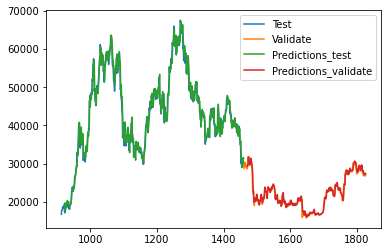

In [12]:
# ploting the actual values and predicted values
plt.plot(test_data.index, test_data['Price'])
plt.plot(val_data.index, val_data['Price'])
plt.plot(test_data.index[-len(y_pred):], y_pred)
plt.plot(val_data.index[-len(y_vpred):], y_vpred)
plt.legend(['Test','Validate', 'Predictions_test','Predictions_validate'])
plt.show()